In [2]:
import pandas as pd
import numpy as np
from transformers import pipeline
from modules.tweet_data import read_raw_data, clean_sentiment
from modules.spacy import spacy_twitter_model
import datetime as dt
import time
import pickle

pd.options.mode.chained_assignment = None  # default='warn'

In [11]:
# sentiment-analysis uses model 'distilbert-base-uncased-finetuned-sst-2-english'
# https://huggingface.co/transformers/_modules/transformers/pipelines.html#TextClassificationPipeline
sentiment_model = pipeline('sentiment-analysis', device=0)

In [3]:
tweet_df = read_raw_data()
#tweet_df = tweet_df['2020-02-01':'2020-02-10']
tweet_df.tweet = clean_sentiment(tweet_df.tweet)

Reading data
Filtering link
Filtering piclink
Filtering hashtag
Filtering email
Filtering add


In [15]:
sentiment = tweet_df[['tweet_id','handle']].copy()
sentiment['sentiment'] = 0
sentiment['score'] = 0

In [16]:
t = time.time()
batch_size = 16
for i in range(0,len(tweet_df),batch_size):
    if i%10000 == 0:
        print("{}/{}, time {:.2f}".format(i, len(tweet_df),(time.time() - t)/60),end="\r")
    sentiment_dict = sentiment_model(tweet_df.tweet.iloc[i:i+batch_size].to_list())
    sentiment.sentiment.iloc[i:i+batch_size] = [1 if d['label'] == 'POSITIVE' else -1 for d in sentiment_dict]
    sentiment.score.iloc[i:i+batch_size] = [d['score'] for d in sentiment_dict]
    
print("{}/{}, time {:.2f}".format(i, len(tweet_df),(time.time() - t)/60),end="\r")

In [17]:
pickle.dump( sentiment, open( "sentiment.p", "wb" ) )

Sentiment stats:
    
Average sentiment
Avg sentiment by person
Avg sentiment by non fintwit?
Average sentiment by fintwit
Average sentiment by trader

When fitting market, can we find the most predictive twitters

In [3]:
sentiment = pickle.load(open( "data/sentiment.p", "rb" ))
classi = pd.read_csv('data/handle_class.csv')
sentiment = pd.merge(sentiment,classi[['class','handle','subclass']],on=['handle'], right_index=True)
sentiment.head()

,tweet_id,handle,sentiment,score,class,subclass
timestamp,,,,,,
2006-09-22 09:02:46,33743,guan,1,0.999717,fintwit,opinion
2006-09-22 09:21:33,33745,guan,1,0.999805,fintwit,opinion
2007-03-08 12:50:52,5929557,guan,1,0.982900,fintwit,opinion
2007-04-06 16:29:24,20844701,guan,1,0.999859,fintwit,opinion
2007-04-07 14:01:37,21447221,guan,-1,0.999554,fintwit,opinion


In [4]:
es = pd.read_csv('data/ES.csv')
es = es[es.Time == '15:00'][['Date','Time','Close']]
es.Date = pd.to_datetime(es.Date +' ' +'15:45')
es.drop('Time',axis=1,inplace=True)
es.set_index('Date', inplace=True)
es['Post'] = np.roll(es['Close'].pct_change(),-1)
date_range = es['2011-12-30':'2020-5-31'].index
date_range

DatetimeIndex(['2011-12-30 15:45:00', '2012-01-03 15:45:00',
               '2012-01-04 15:45:00', '2012-01-05 15:45:00',
               '2012-01-06 15:45:00', '2012-01-09 15:45:00',
               '2012-01-10 15:45:00', '2012-01-11 15:45:00',
               '2012-01-12 15:45:00', '2012-01-13 15:45:00',
               ...
               '2020-05-15 15:45:00', '2020-05-18 15:45:00',
               '2020-05-19 15:45:00', '2020-05-20 15:45:00',
               '2020-05-21 15:45:00', '2020-05-22 15:45:00',
               '2020-05-26 15:45:00', '2020-05-27 15:45:00',
               '2020-05-28 15:45:00', '2020-05-29 15:45:00'],
              dtype='datetime64[ns]', name='Date', length=2096, freq=None)

In [5]:
def final_score(x):
    return (x.sentiment * x.score).mean()

sentiment_features = pd.DataFrame(index = date_range[1:])
date_bins = pd.cut(sentiment.index, bins=date_range)

# Daily Average
sentiment_features['daily_average'] = sentiment.groupby(date_bins).apply(final_score)

#Average by user class
class_averages = sentiment.groupby([date_bins,'class']).apply(final_score).unstack().add_prefix('daily_average_')
sentiment_features[class_averages.columns] = class_averages
del class_averages

sentiment_features['daily_average_trader'] = sentiment.groupby([date_bins,'subclass']).apply(final_score)[:,'trader']

sentiment_features.head()

,daily_average,daily_average_fintwit,daily_average_news,daily_average_politics,daily_average_trader
Date,,,,,
2012-01-03 15:45:00,-0.175479,-0.178582,-0.191966,-0.146552,-0.154668
2012-01-04 15:45:00,-0.266243,-0.334767,-0.166645,-0.239557,-0.336303
2012-01-05 15:45:00,-0.337371,-0.384344,-0.291280,-0.243320,-0.368697
2012-01-06 15:45:00,-0.325877,-0.355626,-0.321614,-0.214214,-0.354338
2012-01-09 15:45:00,-0.252546,-0.257554,-0.255376,-0.235941,-0.223905


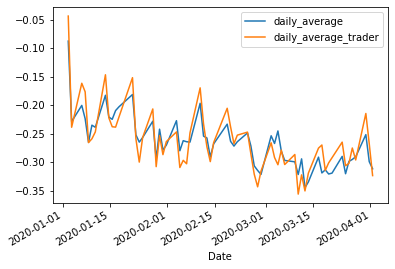

In [9]:
sentiment_features[['daily_average','daily_average_trader']]['2020-01-01':'2020-04-01'].plot()

In [10]:
user_features = sentiment.groupby([date_bins, 'handle']).apply(final_score).unstack()
user_features.index = sentiment_features.index

In [11]:
user_features.head()

handle,4xguy,50Pips,AFP,AJENews,AJEnglish,AJInsight,AP,AaronMehta,AlArabiya_Eng,AlbertoNardelli,...,NickGiva,WildcatTrader,HedgeDirty,RandolphDuke7,UreshP,architectrader,mitchprothero,jayho79,macrokurd,MarketElf
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 15:45:00,0.011648,0.074823,-0.058421,-0.459384,-0.213521,-0.990219,-0.486813,-0.997481,-0.349743,-0.132478,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04 15:45:00,0.414961,-0.034361,-0.271473,-0.380858,-0.166281,NaN,-0.229093,-0.079628,-0.254802,0.008037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05 15:45:00,-0.328351,-0.023131,-0.340646,-0.431978,-0.219482,NaN,-0.458992,-0.001567,-0.604528,-0.208913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06 15:45:00,0.093484,0.024120,-0.080661,-0.791466,-0.482680,NaN,-0.455284,-0.228615,-0.399301,-0.104618,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09 15:45:00,0.000564,0.003127,-0.146910,-0.581568,-0.363977,-0.982943,-0.416436,-0.666344,-0.327697,-0.102382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
